<a href="https://colab.research.google.com/github/rhirwa/obesity-risk-classification/blob/main/obesity_risk_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F68479%2F7609535%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240410%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240410T231847Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D792b6e56baaf71120f1727eb88f032ec4177d410c31efc35d337e293639f7837882f81930e7445e905136bc0f60d052f04e2c0583b56d6bc915606591f9a5f0fd34906b0ee1ad2e013a4e346c29fc081b82ca460a03fe9bbafd680014c1e2c5e19412c198410de1080cae5deac0bcb1bb23534cd64de509e5d6592a10083cebe8d82320a750afc072a93d4a2f2a9b2712fc6c68156a0c2c510acde0f9927bc6d6f530784a08ecc6e37714e4ff52f9c630ebd6b3594ee58719a1da76473b31ebe9cf44744061b44149b178e4997e2ad81d18daf65c66e97e0d833a2d6475b726c60c2a31dbbbe442d6958300957618cf5caec2e84d990b88f73f908ac709cfb45'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 939479 bytes downloaded
Downloaded and uncompressed: playground-series-s4e2
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/test.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/sample_submission.csv


In [3]:
# import data
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col='id')

In [4]:
# overview data
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# check for null values
train.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [6]:
# check for duplicates
train.duplicated().sum()

0

In [7]:
# view general info
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             20758

<Axes: xlabel='NObeyesdad'>

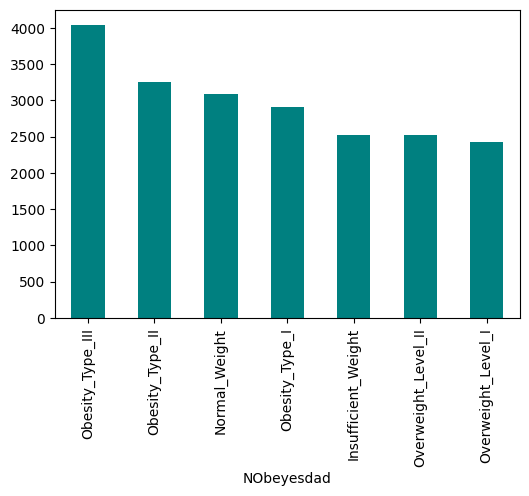

In [8]:
# check label count
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
train['NObeyesdad'].value_counts().plot(kind='bar', color='teal', label='Label Count')

In [9]:
# grab numerical data
num_cols = [col for col in train.columns if train[col].dtype == 'float64']
num_set = train[num_cols]
num_set.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [10]:
# categorical columns
cat_cols = [col for col in train.columns if train[col].dtype=='object']

# drop the label column
cat_cols.remove('NObeyesdad')

# grab categorical data
cat_set = train[cat_cols]
cat_set.describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
count,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
freq,10422,17014,18982,17529,20513,20071,15066,16687


In [11]:
# silence warnings
import warnings
warnings.simplefilter('ignore')

### Visualize data

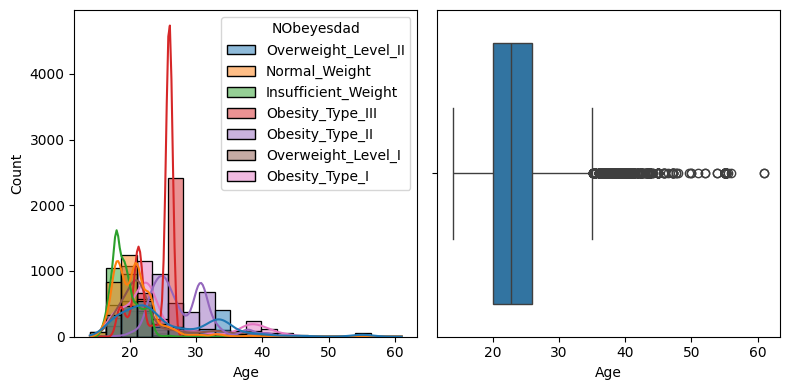

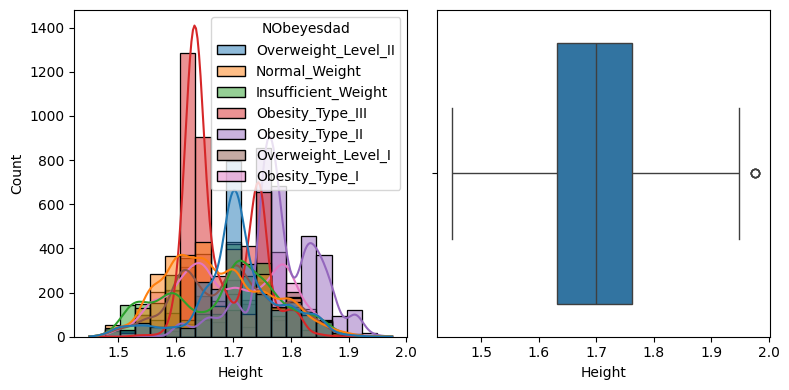

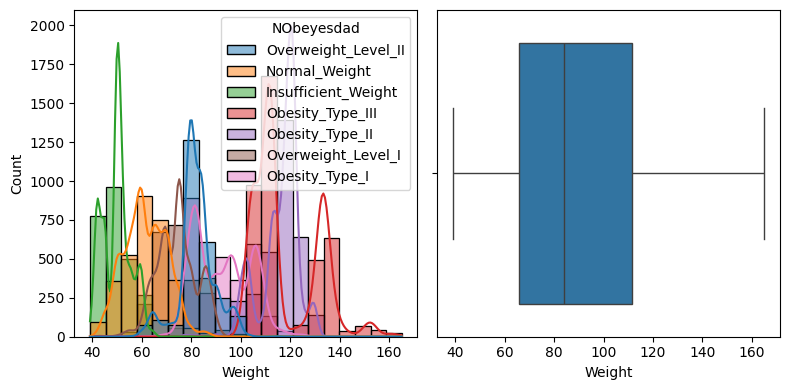

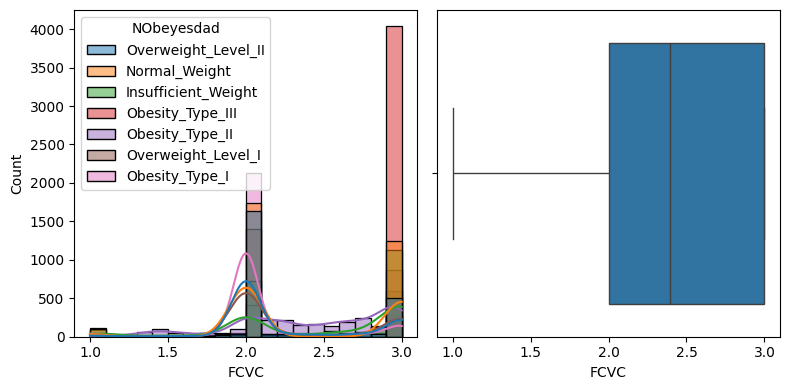

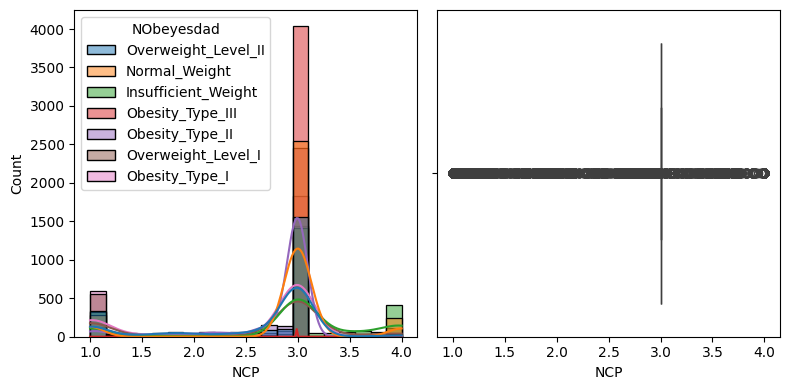

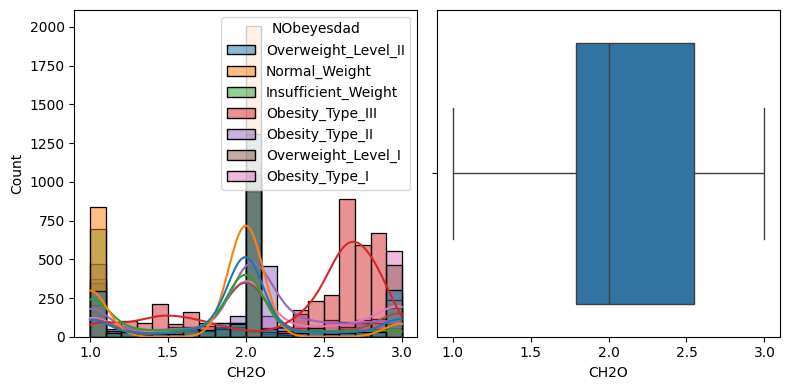

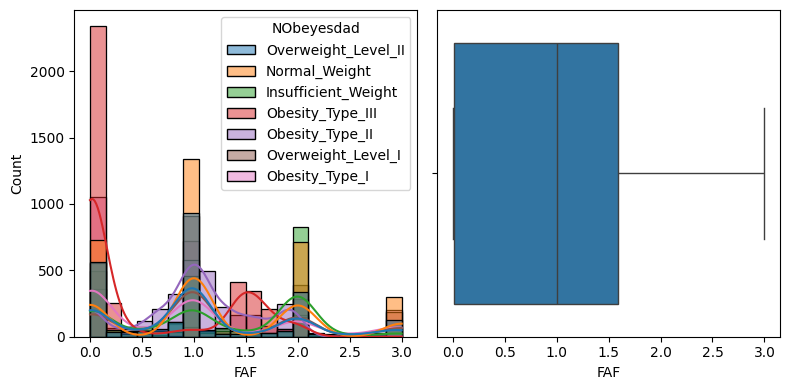

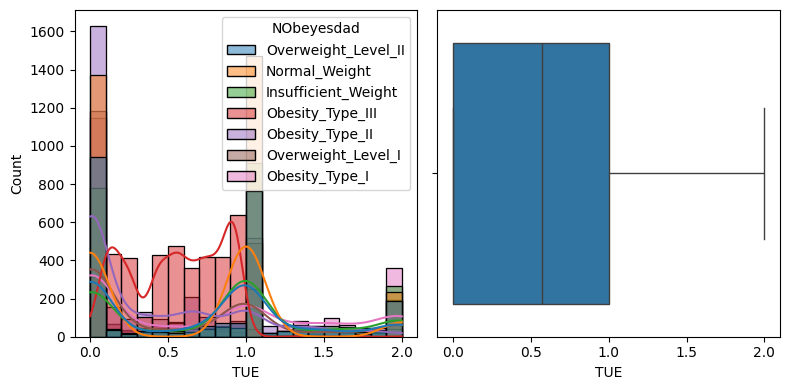

In [12]:
# check distributions of numeric data
import seaborn as sns

for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    sns.histplot(data=train, x=num_set[col], hue=train['NObeyesdad'], bins=20, label=col, ax=ax[0], kde=True)
    sns.boxplot(data=train, x=num_set[col], ax=ax[1])
    plt.tight_layout()

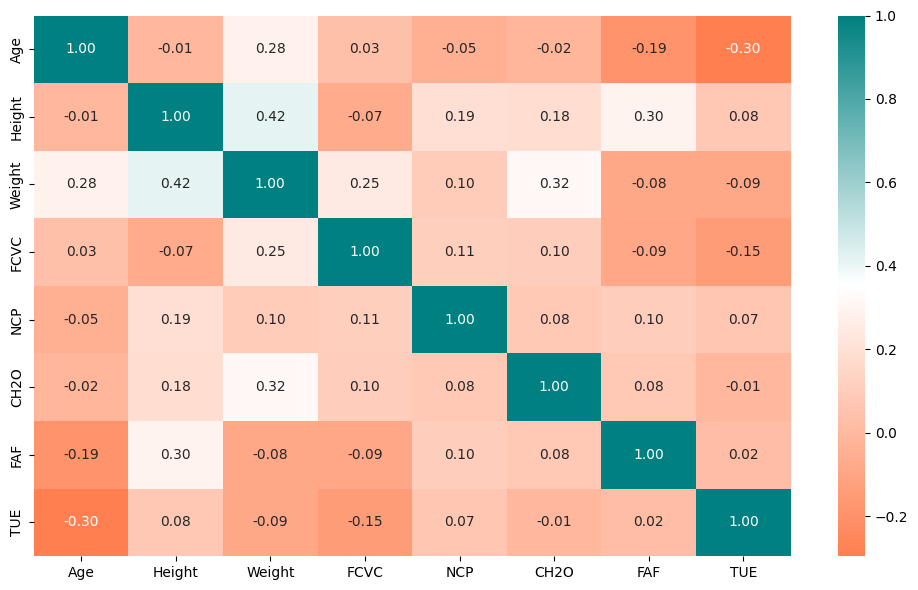

In [13]:
# check correlations
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(10,6))
colors = ['coral', 'white', 'teal']
cmap = LinearSegmentedColormap.from_list('custom_coral_map', colors)

num_corr = num_set.corr()
sns.heatmap(num_corr, cmap=cmap, annot=True, fmt='.2f')
plt.tight_layout()

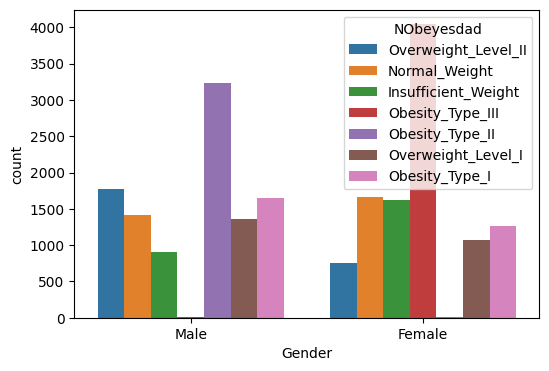

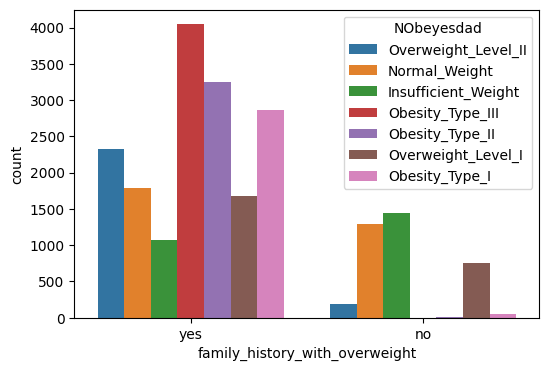

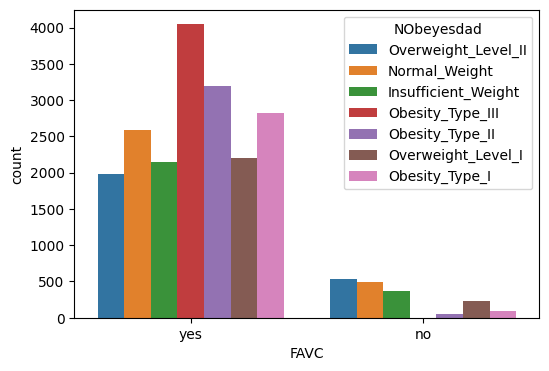

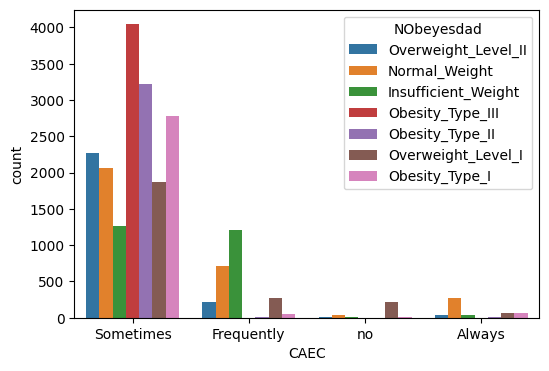

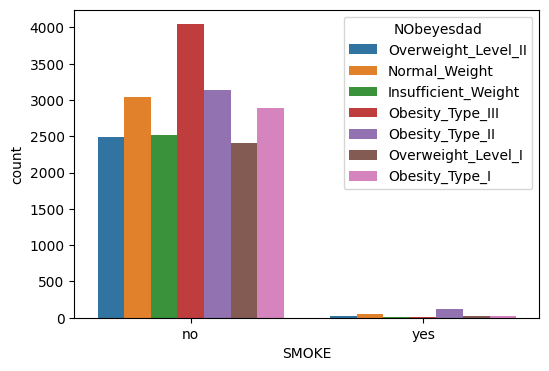

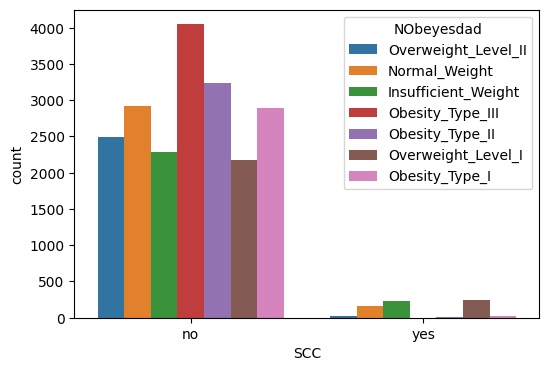

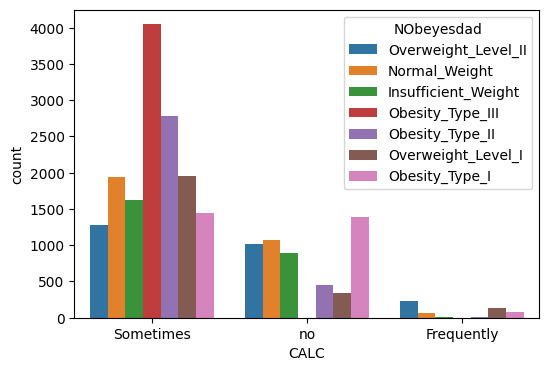

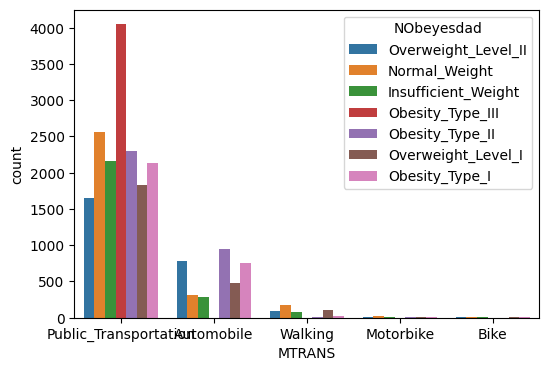

In [14]:
# check distributions for categorical data
for col in cat_cols:
    plt.subplots(figsize=(6,4))
    sns.countplot(data=train, x=col, hue=train['NObeyesdad'])

### Feature engineering

In [15]:
def engineer_features(data):
    # prepare to store new columns
    engineered_num_cols = []

    # create a bmi feature
    data['BMI'] = data['Weight'] / (data['Height'] ** 2)
    engineered_num_cols.append('BMI')

    # create a veg meals
    data['Veg_Meals'] = data['FCVC'] * data['NCP']
    engineered_num_cols.append('Veg_Meals')

    return data, engineered_num_cols

# add engineered features to the train set
train_set, engineered_num_cols = engineer_features(train)

# add engineered columns to numeric columns
num_cols = num_cols + engineered_num_cols

### Preprocessing

In [16]:
# scale numeric data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train_set[num_cols])

# define a scaling function
def scale_nums(data, columns):
    scaled_data = sc.transform(data[columns])
    scaled_df = pd.DataFrame(scaled_data, columns=columns, index=data.index)
    return scaled_df

# scale numeric data
num_set = scale_nums(train_set, num_cols)

In [17]:
# encode categorical data
def encode_data(data, columns):
    encoded_data = pd.get_dummies(data[columns], dtype=int)
    return encoded_data

# encode categorical data
cat_set = encode_data(train, cat_cols)

In [18]:
# reunite numeric and categorical data
def concatenate_data(num_set, cat_set):
    train_set = pd.concat([num_set, cat_set], axis=1)
    return train_set

# concatenate numeric and categorical data
X = concatenate_data(num_set, cat_set)

In [19]:
# encode label data
from sklearn.preprocessing import LabelEncoder

y = train.pop('NObeyesdad')
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

### Modeling the data

In [20]:
# define baseline models
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# define models
xgb_classifier = XGBClassifier()
random_forest = RandomForestClassifier()
models = [xgb_classifier, random_forest]

# check the baseline scores
for model in models:
    kfolds = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfolds, scoring='accuracy').mean()
    print(f"{model}: {scores}")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...): 0.9037482445506928
RandomForestClassifier(): 0.9001833770959918


### Hyperparameter tuning

In [21]:
# # tune the xgboost model's parameters
# from sklearn.model_selection import GridSearchCV, KFold

# param_grid = {
#     'n_estimators': [1000, 1500],
#     'learning_rate': [0.01, 0.001],
#     'max_depth': [6, 8]
# }

# # define the models
# kfolds = KFold(n_splits=3, shuffle=True, random_state=42)
# estimator = XGBClassifier()

# # fit the grid search model
# grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=kfolds, scoring='accuracy')
# grid_search.fit(X, y)

# # grab best estimators
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # print the best estimators
# print(f"The best parameters are: {best_params}")
# print(f"The best score is: {best_score}")

In [22]:
# get best params
best_params = {
    'learning_rate': 0.01,
    'max_depth': 6,
    'n_estimators': 1500}

In [23]:
# define the final model
final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [24]:
# preprocessing pipeline
test_set = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col='id')
test_set, _ = engineer_features(test_set)
num_set = scale_nums(test_set, num_cols)
cat_set = encode_data(test_set, cat_cols)
test = concatenate_data(num_set, cat_set)
test = test.drop('CALC_Always', axis=1)

In [25]:
# get sample submission
submission_id = test.index
predicted_labels = final_model.predict(test)
n_predictions = le.inverse_transform(predicted_labels)

# save the submission file
submission_sample = pd.DataFrame({
    'id': submission_id,
    'NObeyesdad': n_predictions
})
submission_sample.to_csv('/kaggle/working/submission.csv', index=False)
submission_sample.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


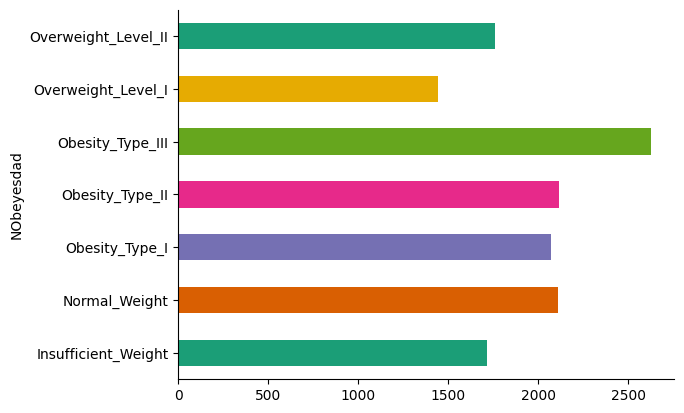

In [26]:
# @title NObeyesdad

from matplotlib import pyplot as plt
import seaborn as sns
submission_sample.groupby('NObeyesdad').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)